# <font color="#114b98">Catégorisez automatiquement des questions</font>

## <font color="#114b98">Notebook de test de différents modèles</font>

**Stack Overflow** est un site célèbre de questions-réponses liées au développement informatique.

L'objectif de ce projet est de développer un système de **suggestion de tags** pour ce site. Celui-ci prendra la forme d’un algorithme de machine learning qui assignera automatiquement plusieurs tags pertinents à une question.

**Livrable** : Un notebook de test de différents modèles

**Objectifs** : Comparer les modèles et générer des tags pour chacun d'entre eux

## <font color="#114b98">Sommaire</font>
[1. Chargement du jeu de données](#section_1)

[2. Approche non supervisée](#section_2)

[3. Approche supervisée](#section_3)

[4. Approche supervisée avec Word Embedding : Word2Vec](#section_4)

[5. Approche supervisée avec Word Embedding : BERT](#section_5)

[6. Approche supervisée avec Sentence Embedding : USE](#section_6)

[7. Choix du modèle pour le code final à déployer](#section_7)

## <font color="#114b98" id="section_1">1. Chargement du jeu de données</font>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import ast
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
plt.rc('axes', titlesize=22)
plt.rc('axes', labelsize=18)
titleprops = {'fontsize':20}
textprops = {'fontsize':15}
plt.style.use('ggplot')

In [3]:
main_path = 'N:/5 - WORK/1 - Projets/Projet 5/'
data = pd.read_csv(main_path+'saved_ressources/'+'data_cleaned_1000t.csv', encoding='utf8')

In [4]:
data["Texts"] = data["Texts"].apply(lambda x: ast.literal_eval(x))

In [5]:
data["Tags"] = data["Tags"].apply(lambda x: ast.literal_eval(x))

In [6]:
sample_size = 20000

In [7]:
def jaccard_similarity(list1, list2):
    set1 = set(list1)
    set2 = set(list2)
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    jaccard_similarity = len(intersection) / len(union)
    return jaccard_similarity

In [8]:
def get_highest_similarity_rows(data, col1, col2, n):
    data["jaccard_similarity"] = data.apply(lambda x: jaccard_similarity(x[col1], x[col2]), axis=1)
    data = data.sort_values(by="jaccard_similarity", ascending=False)
    return data.head(n)

In [9]:
data_sample = get_highest_similarity_rows(data, "Tags", "Texts", sample_size)
data_sample = data_sample[['Tags', 'Texts', 'Sentences', 'jaccard_similarity']]
data_sample.drop(['jaccard_similarity'], axis=1, inplace=True)
data_sample.reset_index(inplace=True, drop=True)

In [10]:
texts_train, texts_eval, \
tags_train, tags_eval, \
sentences_train, sentences_eval = train_test_split(
    data_sample["Texts"],
    data_sample["Tags"],
    data_sample["Sentences"],
    test_size=0.5,
    random_state=42
)

In [11]:
texts_list = texts_train.to_list()
tags_list = tags_train.to_list()
sentences_list = sentences_train.to_list()
flat_texts = [" ".join(text) for text in texts_list]
flat_tags = [" ".join(tag) for tag in tags_list]
vocabulary_texts = list(set([word for item in texts_list for word in item]))
vocabulary_tags = list(set([word for item in tags_list for word in item]))

In [12]:
texts_list_eval = texts_eval.to_list()
tags_list_eval = tags_eval.to_list()
sentences_list_eval = sentences_eval.to_list()
flat_texts_eval = [" ".join(text) for text in texts_list_eval]
flat_tags_eval = [" ".join(tag) for tag in tags_list_eval]
vocabulary_texts_eval = list(set([word for item in texts_list_eval for word in item]))
vocabulary_tags_eval = list(set([word for item in tags_list_eval for word in item]))

In [13]:
words = []
for text in flat_tags:
    words.extend(text.split())

counter = Counter(words)
top_500_tags = [word for word, count in counter.most_common(500)]

In [14]:
words = []
for text in flat_tags_eval:
    words.extend(text.split())

counter = Counter(words)
top_200_tags_eval = [word for word, count in counter.most_common(200)]

In [15]:
mlb = MultiLabelBinarizer(classes=top_500_tags)
tags_mlb = mlb.fit_transform(tags_list)

In [70]:
def jaccard_index(list1, list2):
    s1 = set(list1)
    s2 = set(list2)
    if not s1 or not s2:
        return 0
    return len(s1 & s2) / len(s1 | s2)

In [71]:
def calculate_scores(tags_list, pred_tags):
    scores = [jaccard_index(t, p) for t, p in zip(tags_list, pred_tags)]
    mean_score = sum(scores) / len(scores)
    return mean_score

In [72]:
def jaccard_index_mod(list1, list2):
    """ 
    Fonction jaccard_index modifiée
    La division ne se fait pas sur l'union des deux set
    mais par le nombre de tags prédits (list2)
    afin de ne pas pénaliser les scores des observations
    avec moins de 5 tags
    """
    s1 = set(list1)
    s2 = set(list2)
    if not s1 or not s2:
        return 0
    return len(s1 & s2) / len(s2)

In [83]:
def calculate_scores_mod(tags_list, pred_tags):
    scores = [jaccard_index_mod(t, p) for t, p in zip(tags_list, pred_tags)]
    mean_score = sum(scores) / len(scores)
    return mean_score

In [80]:
def plot_similar_tags(tags_list, pred_tags, method):
    mean_score = calculate_scores(tags_list, pred_tags)
    mean_score_mod = calculate_scores_mod(tags_list, pred_tags)
    similar_counts = []
    
    for pred_tags, tags_list in zip(pred_tags, tags_list):
        similar_words = set(pred_tags) & set(tags_list)
        similar_counts.append(len(similar_words))

    counter = Counter(similar_counts)
    counter = dict(sorted(counter.items()))

    # Add missing keys to counter with value 0
    keys = set(range(0, 6))
    missing_keys = keys - set(counter.keys())
    for key in missing_keys:
        counter[key] = 0
    sorted_counter = dict(sorted(counter.items()))
        
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle(f"Similarité des tags avec la méthode {method}", fontsize=14, fontweight='bold', y=1.05)
    axs[0].bar(sorted_counter.keys(), sorted_counter.values())
    axs[0].set_xticks(range(0,6,1))
    axs[0].set_xticklabels(sorted_counter.keys(), rotation=0)
    axs[0].set_xlabel('Nombre de tags similaires', fontsize=11)
    axs[0].set_ylabel("Nombre d'observations", fontsize=11)
    axs[0].set_title("Nombre d'observations avec un\n nombre de tags similaires", fontsize=12)   
    axs[1].pie(sorted_counter.values(), labels=sorted_counter.keys(), autopct='%1.1f%%', pctdistance=0.8)
    axs[1].legend(title='Tags\nSimilaires', bbox_to_anchor=(1, 0.9), prop={'size': 8}, title_fontsize=10)
    axs[1].set_title("Pourcentage d'observations avec \n un nombre de tags similaires", fontsize=12)
    
    textstr = ''.join((
        r'Jaccard_index = %.2f' % (mean_score, )))
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    axs[1].text(0.8, 0.05, textstr, transform=axs[1].transAxes, fontsize=12,
                verticalalignment='top', bbox=props)
    
    textstr = ''.join((
        r'Jaccard_index_mod = %.2f' % (mean_score_mod, )))
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    axs[1].text(0.8, 0, textstr, transform=axs[1].transAxes, fontsize=12,
                verticalalignment='top', bbox=props)
    
    plt.show()

## <font color="#114b98" id="section_4">4. Approche supervisée avec Word Embedding : Doc2Vec</font>

### Dataset d'essais

In [51]:
import multiprocessing
import gensim
from gensim.models import Word2Vec
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from tensorflow.keras import Sequential
from keras.layers import Dense, Dropout, BatchNormalization

In [52]:
# Preprocess the sentences
sentences = [gensim.utils.simple_preprocess(text) for text in sentences_list]

In [53]:
tagged_data = [TaggedDocument(words=sent, tags=[str(i)]) for i, sent in enumerate(sentences)]

# Train a Doc2Vec model
d2v_model = Doc2Vec(tagged_data, vector_size=100, window=2, min_count=1, workers=4)

# Use the trained model to infer vectors for each sentence
sentence_vectors = [d2v_model.infer_vector(sent) for sent in sentences]

# Find the most similar sentences for each sentence based on the inferred vectors
similar_sentences = [d2v_model.docvecs.most_similar([vec], topn=5) for vec in sentence_vectors]

# Convert the indices of similar sentences back to their respective tags
pred_tags_d2v = [[sentences[int(index)][0] for index, similarity in sim_sents] for sim_sents in similar_sentences]

In [54]:
pred_tags_d2v[0:5]

[['problems', 'jquery', 'laravel', 'data', 'how'],
 ['convert', 'can', 'scrollintoview', 'how', 'iphone'],
 ['selenium', 'capybara', 'selenium', 'protractor', 'python'],
 ['javafx', 'how', 'importing', 'class', 'using'],
 ['complexity', 'overriding', 'default', 'python', 'llvm']]

In [55]:
tags_list[0:5]

[['php', 'jquery', 'ajax', 'internet-explorer', 'cross-domain'],
 ['c#', '.net', 'wpf', 'winforms', 'xaml'],
 ['java', 'google-chrome', 'selenium', 'selenium-webdriver', 'click'],
 ['java', 'linux', 'ubuntu', 'intellij-idea', 'javafx'],
 ['algorithm',
  'language-agnostic',
  'programming-languages',
  'functional-programming',
  'complexity-theory']]

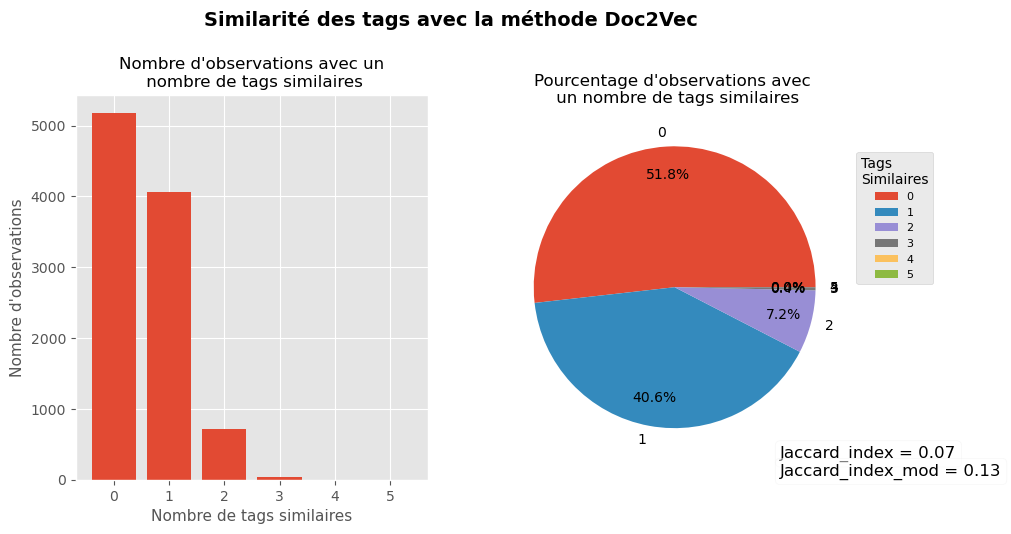

In [84]:
plot_similar_tags(tags_list, pred_tags_d2v, 'Doc2Vec')

# Avec top 500 tags

In [57]:
similar_sentences = [d2v_model.docvecs.most_similar([vec], topn=40) for vec in sentence_vectors]
pred_tags_d2v_500 = []
for sim_sents in similar_sentences:
    used_tags = set()
    tags = [sentences[int(index)][0] for index, similarity in sim_sents if sentences[int(index)][0] in top_500_tags]
    pred_tags_filtered = [tag for tag in tags if tag not in used_tags and (used_tags.add(tag) or True)][:5]
    pred_tags_d2v_500.append(pred_tags_filtered)

In [58]:
pred_tags_d2v_500[0:5]

[['jquery', 'laravel', 'cors', 'angularjs', 'flask'],
 ['iphone', 'wpf', 'listview', 'silverlight', 'uiview'],
 ['selenium', 'capybara', 'protractor', 'python', 'junit'],
 ['class', 'gradle', 'maven', 'java', 'tomcat'],
 ['python', 'string', 'merge', 'memory', 'numpy']]

In [59]:
tags_list[0:5]

[['php', 'jquery', 'ajax', 'internet-explorer', 'cross-domain'],
 ['c#', '.net', 'wpf', 'winforms', 'xaml'],
 ['java', 'google-chrome', 'selenium', 'selenium-webdriver', 'click'],
 ['java', 'linux', 'ubuntu', 'intellij-idea', 'javafx'],
 ['algorithm',
  'language-agnostic',
  'programming-languages',
  'functional-programming',
  'complexity-theory']]

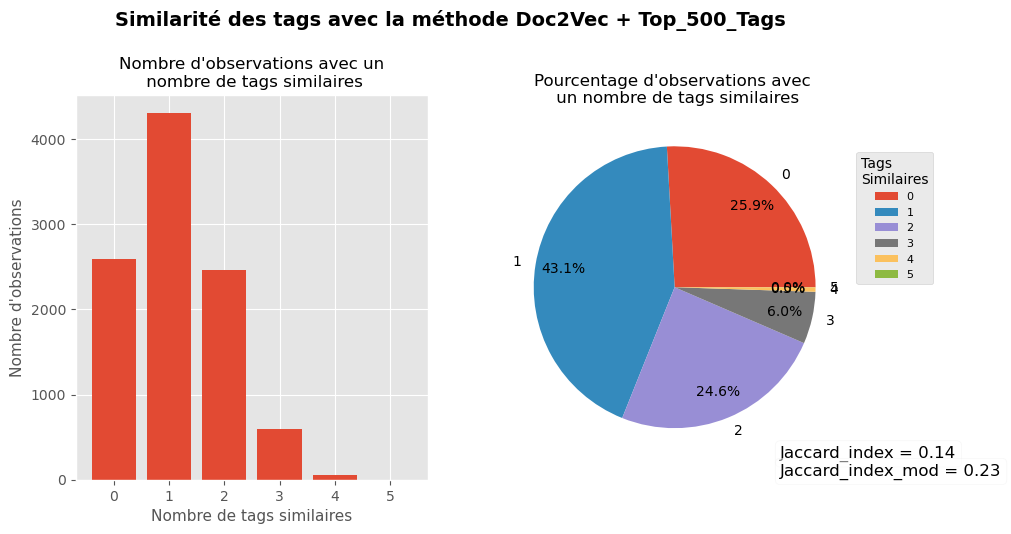

In [85]:
plot_similar_tags(tags_list, pred_tags_d2v_500, 'Doc2Vec + Top_500_Tags')

In [29]:
# Convert the sentences into numerical data
encoded_sentences = np.array([d2v_model.docvecs[sent.tags[0]] for sent in tagged_data])

In [30]:
# Split the data into training and testing sets
train_sentences, test_sentences, train_tags, test_tags = train_test_split(encoded_sentences, tags_mlb, test_size=0.2, random_state=0)

In [31]:
# Define the neural network
d2v_nn_model = Sequential([
    Dense(512, activation='relu', input_shape=(100,)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(len(mlb.classes_), activation='sigmoid')
])

In [32]:
# Compile the model
d2v_nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [33]:
# Train the model and store the history object
history = d2v_nn_model.fit(train_sentences, train_tags, verbose=1, 
                           epochs=200, batch_size=32, 
                           validation_data=(test_sentences, test_tags),
                           workers=multiprocessing.cpu_count())

Epoch 1/200
250/250 [==============================] - 1s 2ms/step - loss: 0.4472 - accuracy: 0.0742 - val_loss: 0.0767 - val_accuracy: 0.2590
Epoch 2/200
250/250 [==============================] - 0s 2ms/step - loss: 0.0624 - accuracy: 0.2931 - val_loss: 0.0435 - val_accuracy: 0.3510
Epoch 3/200
250/250 [==============================] - 0s 2ms/step - loss: 0.0468 - accuracy: 0.3269 - val_loss: 0.0409 - val_accuracy: 0.3845
Epoch 4/200
250/250 [==============================] - 0s 2ms/step - loss: 0.0440 - accuracy: 0.3489 - val_loss: 0.0393 - val_accuracy: 0.4180
Epoch 5/200
250/250 [==============================] - 0s 2ms/step - loss: 0.0423 - accuracy: 0.3602 - val_loss: 0.0377 - val_accuracy: 0.4375
Epoch 6/200
250/250 [==============================] - 0s 2ms/step - loss: 0.0410 - accuracy: 0.3747 - val_loss: 0.0366 - val_accuracy: 0.4635
Epoch 7/200
250/250 [==============================] - 0s 2ms/step - loss: 0.0397 - accuracy: 0.3927 - val_loss: 0.0353 - val_accuracy: 0.4670

Epoch 58/200
250/250 [==============================] - 0s 2ms/step - loss: 0.0285 - accuracy: 0.4716 - val_loss: 0.0263 - val_accuracy: 0.5190
Epoch 59/200
250/250 [==============================] - 0s 2ms/step - loss: 0.0285 - accuracy: 0.4652 - val_loss: 0.0264 - val_accuracy: 0.5155
Epoch 60/200
250/250 [==============================] - 0s 2ms/step - loss: 0.0284 - accuracy: 0.4688 - val_loss: 0.0262 - val_accuracy: 0.5040
Epoch 61/200
250/250 [==============================] - 0s 2ms/step - loss: 0.0285 - accuracy: 0.4704 - val_loss: 0.0262 - val_accuracy: 0.5145
Epoch 62/200
250/250 [==============================] - 0s 2ms/step - loss: 0.0285 - accuracy: 0.4685 - val_loss: 0.0262 - val_accuracy: 0.5070
Epoch 63/200
250/250 [==============================] - 0s 2ms/step - loss: 0.0283 - accuracy: 0.4703 - val_loss: 0.0263 - val_accuracy: 0.5015
Epoch 64/200
250/250 [==============================] - 0s 2ms/step - loss: 0.0282 - accuracy: 0.4821 - val_loss: 0.0263 - val_accuracy:

Epoch 115/200
250/250 [==============================] - 0s 2ms/step - loss: 0.0268 - accuracy: 0.4864 - val_loss: 0.0256 - val_accuracy: 0.5070
Epoch 116/200
250/250 [==============================] - 0s 2ms/step - loss: 0.0267 - accuracy: 0.4843 - val_loss: 0.0256 - val_accuracy: 0.5140
Epoch 117/200
250/250 [==============================] - 0s 2ms/step - loss: 0.0268 - accuracy: 0.4852 - val_loss: 0.0256 - val_accuracy: 0.5165
Epoch 118/200
250/250 [==============================] - 0s 2ms/step - loss: 0.0267 - accuracy: 0.4785 - val_loss: 0.0255 - val_accuracy: 0.5165
Epoch 119/200
250/250 [==============================] - 0s 2ms/step - loss: 0.0269 - accuracy: 0.4800 - val_loss: 0.0257 - val_accuracy: 0.5270
Epoch 120/200
250/250 [==============================] - 0s 2ms/step - loss: 0.0268 - accuracy: 0.4849 - val_loss: 0.0256 - val_accuracy: 0.5305
Epoch 121/200
250/250 [==============================] - 0s 2ms/step - loss: 0.0267 - accuracy: 0.4908 - val_loss: 0.0256 - val_ac

250/250 [==============================] - 0s 2ms/step - loss: 0.0260 - accuracy: 0.4989 - val_loss: 0.0255 - val_accuracy: 0.5240
Epoch 172/200
250/250 [==============================] - 0s 2ms/step - loss: 0.0259 - accuracy: 0.4956 - val_loss: 0.0254 - val_accuracy: 0.5130
Epoch 173/200
250/250 [==============================] - 0s 2ms/step - loss: 0.0259 - accuracy: 0.4940 - val_loss: 0.0255 - val_accuracy: 0.5210
Epoch 174/200
250/250 [==============================] - 0s 2ms/step - loss: 0.0259 - accuracy: 0.4956 - val_loss: 0.0254 - val_accuracy: 0.5170
Epoch 175/200
250/250 [==============================] - 0s 2ms/step - loss: 0.0259 - accuracy: 0.4924 - val_loss: 0.0253 - val_accuracy: 0.5165
Epoch 176/200
250/250 [==============================] - 0s 2ms/step - loss: 0.0260 - accuracy: 0.4930 - val_loss: 0.0255 - val_accuracy: 0.5240
Epoch 177/200
250/250 [==============================] - 0s 2ms/step - loss: 0.0257 - accuracy: 0.4956 - val_loss: 0.0254 - val_accuracy: 0.5210

In [34]:
def plot_epochs(history):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Validation'], loc='lower right')
    
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model loss')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='upper right')
    
    plt.show()

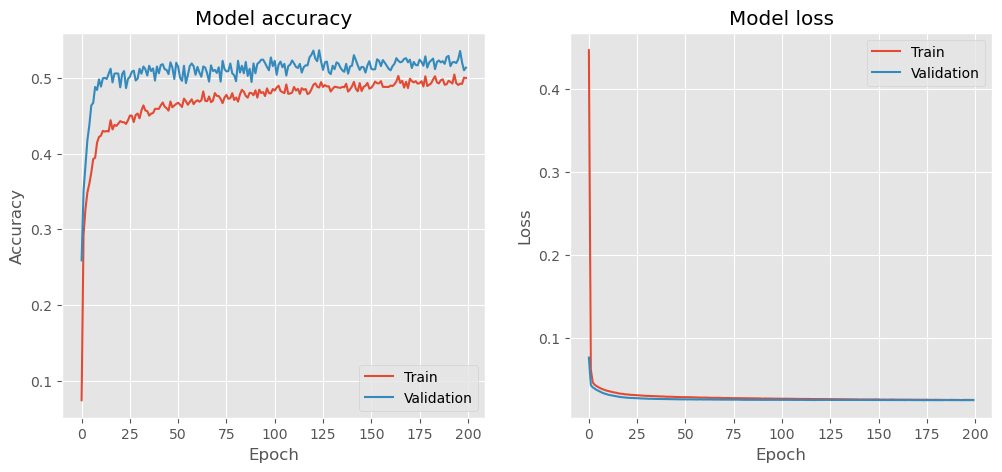

In [35]:
plot_epochs(history)

In [36]:
# Use the trained model to predict the tags for each sentence
pred_probs_d2v_500_nn = d2v_nn_model.predict(test_sentences)

63/63 [==============================] - 0s 872us/step


In [37]:
# Find the top 5 tags for each sentence
pred_tags_d2v_500_nn = []
for sentence_probs in pred_probs_d2v_500_nn:
    top_indexes = sentence_probs.argsort()[-5:][::-1]
    pred_tags_d2v_500_nn.append([mlb.classes_[i] for i in top_indexes])

In [38]:
pred_tags_d2v_500_nn[0:5]

[['c++', 'c', 'gcc', 'android', 'linux'],
 ['c#', 'list', '.net', 'arrays', 'linq'],
 ['java', 'spring', 'spring-mvc', 'spring-boot', 'jsp'],
 ['python', 'html', 'file', 'javascript', 'csv'],
 ['c++', 'c', 'gcc', 'integer', 'floating-point']]

In [39]:
tags_list_ = mlb.inverse_transform(test_tags)
tags_list_[0:5]

[('linux', 'gcc', 'command-line', 'x86', 'linker'),
 ('c#', 'list', 'oop', 'foreach', 'copy'),
 ('java', 'spring', 'spring-mvc', 'jsp', 'error-handling'),
 ('c#', 'wpf', 'visual-studio', 'xaml', 'visual-studio-2010'),
 ('c', 'types', 'type-conversion', 'integer', 'double')]

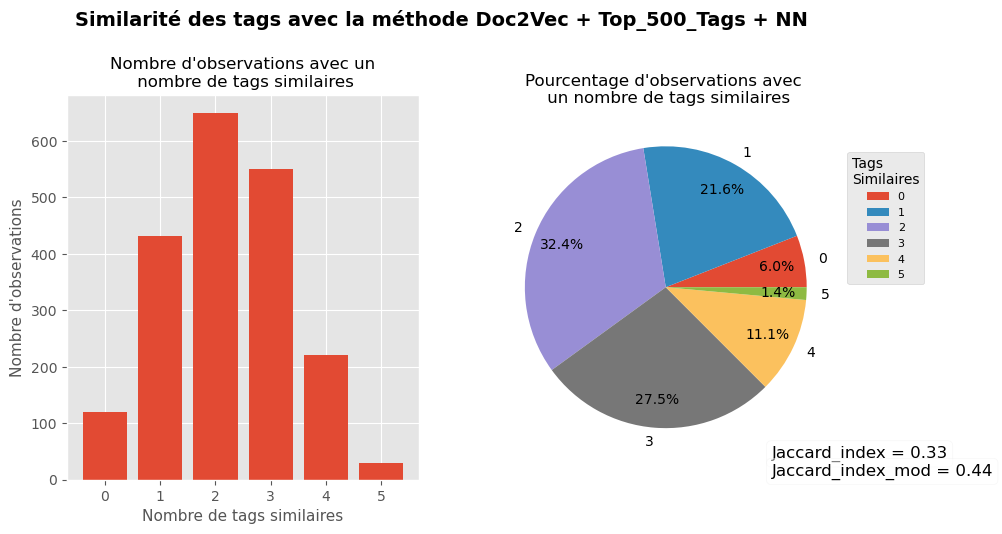

In [86]:
plot_similar_tags(tags_list_, pred_tags_d2v_500_nn, 'Doc2Vec + Top_500_Tags + NN')

### ON NEW DATA !

In [91]:
# Preprocess the sentences
sentences_eval = [gensim.utils.simple_preprocess(text) for text in sentences_list_eval]

In [92]:
tagged_data_eval = [TaggedDocument(words=sent, tags=[str(i)]) for i, sent in enumerate(sentences_eval)]
encoded_sentences_eval = np.array([d2v_model.infer_vector(sent.words) for sent in tagged_data_eval])
pred_probs_d2v_500_nn_eval = d2v_nn_model.predict(encoded_sentences_eval)
pred_tags_d2v_500_nn_eval = []
for sentence_probs in pred_probs_d2v_500_nn_eval:
    top_indexes = sentence_probs.argsort()[-5:][::-1]
    pred_tags_d2v_500_nn_eval.append([mlb.classes_[i] for i in top_indexes])
pred_tags_d2v_500_nn_eval[0:5]

313/313 [==============================] - 0s 818us/step


In [94]:
tags_list_eval[0:5]

[['java', 'spring', 'websocket', 'spring-boot', 'push-notification'],
 ['android', 'cordova', 'ionic-framework', 'ionic2', 'ionic3'],
 ['python', 'linux', 'opencv', 'ffmpeg', 'pipe'],
 ['scala', 'collections', 'vector', 'clojure', 'tree'],
 ['python', 'django', 'windows', 'redis', 'celery']]

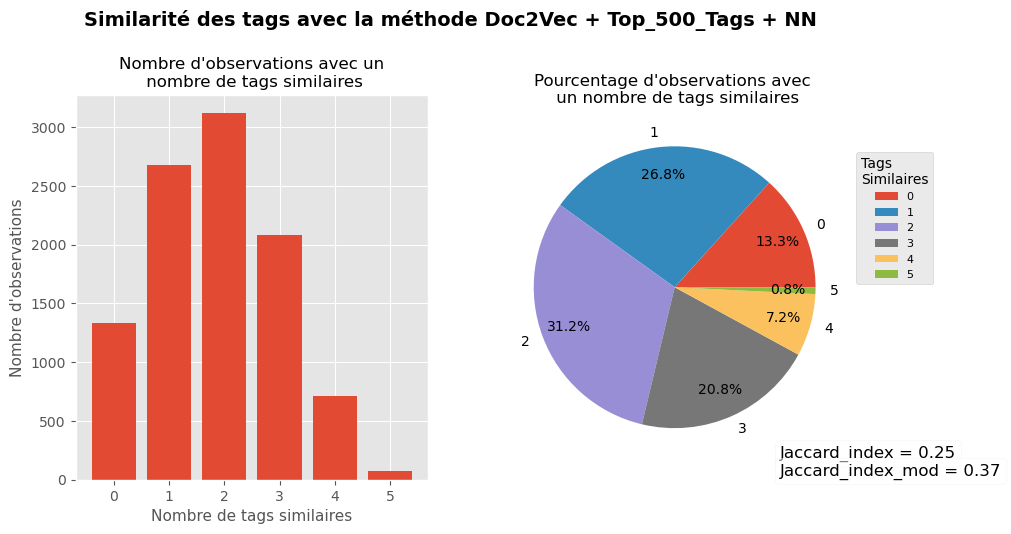

In [95]:
plot_similar_tags(tags_list_eval, pred_tags_d2v_500_nn_eval, 'Doc2Vec + Top_500_Tags + NN')